In [1]:
### Init network Build
import numpy as np
import re
from pathlib import Path
from PIL import Image, ImageEnhance
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from IPython.display import display
import pandas as pd
from osgeo import gdal
import keras
import time
import tensorflow as tf
print(tf.__version__, 'tf')
print(keras.__version__, 'keras')


2.3.0 tf
2.4.3 keras


In [2]:
#from tensorflow.python.client import device_lib
#print(device_lib.list_local_devices())

In [3]:
# define the directory where the downloaded TIF images are
dl_dir = '/data/image_final2'
tif_list = [f for f in Path(dl_dir).iterdir() if '.tif' in str(f)]
print(len(tif_list))

133373


In [4]:
#Run this cell to generate a lookup table for images and their file location
def create_image_lookup(tiff_image_list):
    
    t0 = time.time()
    list_rows = []
    for v in tiff_image_list:
        #print(v)
        #nl = v.name.split('_')[3:7]
        nll = re.split('_|-',str(v))
        nl = nll[4:7]
        #print(nl)
        #print('-'.join(nll[7:-2]))
        nl.append('-'.join(nll[7:-2])) # rejoin the da num and append da num
        nl.append(v)
        #print(nl)
        list_rows.append(nl)
        
    columns = ['img_res', 'img_type', 'img_index', 'da_num', 'img_path']
    df = pd.DataFrame(list_rows, columns = columns)
    print('dataframe shape:', df.shape)
    print('seconds taken:', time.time()-t0)
    return df
df = create_image_lookup(tif_list)
#df.head()

df_labels = pd.read_csv("Madhukar/Archived/Data_combined_regular_clean.csv", encoding = "ISO-8859-1")
df_labels = df_labels[['da_number', 'cwa_determination']]


df_merged = pd.merge(df, df_labels, left_on = 'da_num', right_on = 'da_number', how = 'left')
print(df_merged.shape)
df_merged.head()

dataframe shape: (133373, 5)
seconds taken: 0.8841249942779541
(133373, 7)


,img_res,img_type,img_index,da_num,img_path,da_number,cwa_determination
0,lores,mndwi,292,LRC-2003-22227,/data/image_final2/GEE_images_final2_lores_mnd...,LRC-2003-22227,1
1,lores,mndvi,9510,SAC-2018-01101,/data/image_final2/GEE_images_final2_lores_mnd...,SAC-2018-01101,0
2,hires,mndwi,8157,SAC-2007-01367,/data/image_final2/GEE_images_final2_hires_mnd...,SAC-2007-01367,0
3,hires,seasonality,11062,SAW-2015-01329,/data/image_final2/GEE_images_final2_hires_sea...,SAW-2015-01329,1
4,lores,srtm,5495,MVP-2020-00252-MHK,/data/image_final2/GEE_images_final2_lores_srt...,MVP-2020-00252-MHK,0


In [5]:
# Number of 0's and 1's for jurisdiction determination (ie labels)
print(df_merged.cwa_determination.isna().value_counts())
df_merged.cwa_determination.value_counts()

False    133373
Name: cwa_determination, dtype: int64


0    83425
1    49948
Name: cwa_determination, dtype: int64

In [6]:
# This function will open a TIF and return a numpy array of the TIF.  
def create_array(tif_image):
    try:
        p = gdal.Open(str(tif_image))
        channels = p.RasterCount

        # iterate through rasters and add each to the list of layer_list
        def create_flush_raster(p,i):
            raster_i = p.GetRasterBand(i)
            arr = np.array(raster_i.ReadAsArray())
            raster_i.FlushCache()
            return arr
                            
        layer_list = [create_flush_raster(p,i) for i in range(1,channels+1)] 
        p.FlushCache() 

    except: 
        print("Error with image:", tif_image)
        return np.nan
    return np.array(layer_list)
x = create_array('/data/image_final2/GEE_images_final2_hires_mndwi_2105_MVK-2016-00239-LCM_mndwi_hires.tif')
print(x.shape)

(1, 256, 256)


In [7]:
x = np.array([np.nan, 0, 3])
np.sum(np.isnan(x))

1

In [8]:
# This function will open each TIF and return the image metrics as defined below.  
#. after running this script verify that the memory cache has been released in linux
#> You may need to run `sudo sync && echo 3 | sudo tee /proc/sys/vm/drop_caches***` to clear the caches

from multiprocessing import Pool
import math

def get_image_metrics(image_path):
    image_arr = create_array(image_path)
    mean_pixel_value = np.nanmean(image_arr)
    std_pixel_value = np.nanstd(image_arr)
    min_pixel_value = np.nanmin(image_arr)
    max_pixel_value = np.nanmax(image_arr)
    num_of_nans = np.sum(np.isnan(image_arr))
    return mean_pixel_value, std_pixel_value, min_pixel_value, max_pixel_value, num_of_nans

def transform_func_pooler(x):
    df_i = x
    print('start')
    df_i['metrics'] = df_i.img_path.apply(get_image_metrics)
    print("end")
    return df_i

print('here.')
def apply_in_parallel(df,chunks = 10):
    t0 = time.time()
    chunk_size = math.ceil(df.shape[0] / chunks)
    print(chunk_size)
    list_of_parameters = [df.iloc[(i-1)*chunk_size:i*chunk_size] for i in range(1,chunks+1)]
#    [print(df_x.shape) for df_x in list_of_parameters ]

    output_dfs = []
    if __name__ == '__main__':
        with Pool(8) as p:
            output_dfs.append(p.map(transform_func_pooler, list_of_parameters))
    print(round(time.time()-t0, 3), 'seconds to finish')
    return pd.concat(output_dfs[0])

df_merged = apply_in_parallel(df_merged, 8)

# seperate the stats into their own column
df_merged['mean'] = df_merged.metrics.apply(lambda x: x[0])
df_merged['stdev'] = df_merged.metrics.apply(lambda x: x[1])
df_merged['min'] = df_merged.metrics.apply(lambda x: x[2])
df_merged['max'] = df_merged.metrics.apply(lambda x: x[3])
df_merged['num_nans'] = df_merged.metrics.apply(lambda x: x[4])
df_merged['district_code'] = df_merged.da_num.apply(lambda x: x[:3])

# save to a csv
df_merged.to_csv('image_metrics_032921_all.csv')
print(df_merged.shape)
df_merged.head()

here.
16672
start
start
start
start
start
start
start
start
Error with image: /data/image_final2/GEE_images_final2_lores_srtm_3995_MVN-2019-00361-ST_srtm_lores.tif


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: Mean of empty slice
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/numpy/lib/nanfunctions.py:1667: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: All-NaN axis encountered
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: All-NaN axis encountered
  del sys.path[0]


Error with image: /data/image_final2/GEE_images_final2_lores_srtm_5857_NAN-2016-01232-USH_srtm_lores.tif


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: Mean of empty slice
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/numpy/lib/nanfunctions.py:1667: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: All-NaN axis encountered
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: All-NaN axis encountered
  del sys.path[0]


Error with image: /data/image_final2/GEE_images_final2_hires_mndvi_6176_NAO-2016-01643-tca_mndvi_hires.tif


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: Mean of empty slice
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/numpy/lib/nanfunctions.py:1667: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: All-NaN axis encountered
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: All-NaN axis encountered
  del sys.path[0]


Error with image: /data/image_final2/GEE_images_final2_hires_srtm_8029_POA-2019-00608_srtm_hires.tif


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: Mean of empty slice
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/numpy/lib/nanfunctions.py:1667: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: All-NaN axis encountered
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: All-NaN axis encountered
  del sys.path[0]


Error with image: /data/image_final2/GEE_images_final2_lores_gmndwi_8029_POA-2019-00608_gmndwi_lores.tif
Error with image: /data/image_final2/GEE_images_final2_lores_gmndwi_8463_SAC-2015-01689_gmndwi_lores.tif
Error with image: /data/image_final2/GEE_images_final2_hires_seasonality_8653_SAC-2016-00990_seasonality_hires.tif


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: Mean of empty slice
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/numpy/lib/nanfunctions.py:1667: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: All-NaN axis encountered
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: All-NaN axis encountered
  del sys.path[0]


Error with image: /data/image_final2/GEE_images_final2_hires_mndvi_8236_SAC-2012-00032_mndvi_hires.tif
end
end
end
end
end
end
end
end
362.744 seconds to finish
(133373, 14)


,img_res,img_type,img_index,da_num,img_path,da_number,cwa_determination,metrics,mean,stdev,min,max,num_nans,district_code
0,lores,mndwi,292,LRC-2003-22227,/data/image_final2/GEE_images_final2_lores_mnd...,LRC-2003-22227,1,"(-0.3306894463763968, 0.09898692070930509, -0....",-0.330689,0.098987,-0.619886,0.607442,0,LRC
1,lores,mndvi,9510,SAC-2018-01101,/data/image_final2/GEE_images_final2_lores_mnd...,SAC-2018-01101,0,"(0.8499159409683785, 0.42667432280059364, -83....",0.849916,0.426674,-83.500000,20.250000,0,SAC
2,hires,mndwi,8157,SAC-2007-01367,/data/image_final2/GEE_images_final2_hires_mnd...,SAC-2007-01367,0,"(-0.40988840562690426, 0.19788100896017022, -0...",-0.409888,0.197881,-0.775182,0.755656,0,SAC
3,hires,seasonality,11062,SAW-2015-01329,/data/image_final2/GEE_images_final2_hires_sea...,SAW-2015-01329,1,"(0.009033203125, 0.27228138247280603, 0, 12, 0)",0.009033,0.272281,0.000000,12.000000,0,SAW
4,lores,srtm,5495,MVP-2020-00252-MHK,/data/image_final2/GEE_images_final2_lores_srt...,MVP-2020-00252-MHK,0,"(211.5080108642578, 18.443937482788826, 174, 2...",211.508011,18.443937,174.000000,259.000000,0,MVP


In [ ]:
# Run this if you want to see the single threaded version of the above function.  
#t0 = time.time()
#df_merged['metrics'] = df_merged.img_path.apply(get_image_metrics)
#print(round(time.time()-t0, 3), 'seconds to finish')
#df_merged.head()

In [9]:
# reload the lookup table with from disk
df_merged = pd.read_csv('image_metrics_032921_all.csv')
df_merged.head()

,Unnamed: 0,img_res,img_type,img_index,da_num,img_path,da_number,cwa_determination,metrics,mean,stdev,min,max,num_nans,district_code
0,0,lores,mndwi,292,LRC-2003-22227,/data/image_final2/GEE_images_final2_lores_mnd...,LRC-2003-22227,1,"(-0.3306894463763968, 0.09898692070930509, -0....",-0.330689,0.098987,-0.619886,0.607442,0,LRC
1,1,lores,mndvi,9510,SAC-2018-01101,/data/image_final2/GEE_images_final2_lores_mnd...,SAC-2018-01101,0,"(0.8499159409683785, 0.42667432280059364, -83....",0.849916,0.426674,-83.500000,20.250000,0,SAC
2,2,hires,mndwi,8157,SAC-2007-01367,/data/image_final2/GEE_images_final2_hires_mnd...,SAC-2007-01367,0,"(-0.40988840562690426, 0.19788100896017022, -0...",-0.409888,0.197881,-0.775182,0.755656,0,SAC
3,3,hires,seasonality,11062,SAW-2015-01329,/data/image_final2/GEE_images_final2_hires_sea...,SAW-2015-01329,1,"(0.009033203125, 0.27228138247280603, 0, 12, 0)",0.009033,0.272281,0.000000,12.000000,0,SAW
4,4,lores,srtm,5495,MVP-2020-00252-MHK,/data/image_final2/GEE_images_final2_lores_srt...,MVP-2020-00252-MHK,0,"(211.5080108642578, 18.443937482788826, 174, 2...",211.508011,18.443937,174.000000,259.000000,0,MVP


(3185, 15)


,Unnamed: 0,img_res,img_type,img_index,da_num,img_path,da_number,cwa_determination,metrics,mean,stdev,min,max,num_nans,district_code
26,26,lores,gmndwi,11648,SAW-2017-00074,/data/image_final2/GEE_images_final2_lores_gmn...,SAW-2017-00074,0,"(-0.37597528, 0.09992297, -0.63723403, 0.90102...",-0.375975,0.099923,-0.637234,0.901027,18,SAW
30,30,lores,gmndwi,13233,SWG-2015-00780,/data/image_final2/GEE_images_final2_lores_gmn...,SWG-2015-00780,1,"(-0.39128152, 0.17849219, -0.6165926, 0.973427...",-0.391282,0.178492,-0.616593,0.973428,72,SWG
57,57,lores,mndwi,2460,MVK-2017-00506-TB,/data/image_final2/GEE_images_final2_lores_mnd...,MVK-2017-00506-TB,0,"(-0.3551741384776393, 0.35559203541923096, -0....",-0.355174,0.355592,-0.656958,0.910112,22,MVK
68,68,lores,gmndwi,10261,SAM-2015-01238-KMN,/data/image_final2/GEE_images_final2_lores_gmn...,SAM-2015-01238-KMN,1,"(0.3387794, 0.61818933, -0.5751009, 0.99737185...",0.338779,0.618189,-0.575101,0.997372,19,SAM
72,72,lores,mndwi,11820,SAW-2017-02366,/data/image_final2/GEE_images_final2_lores_mnd...,SAW-2017-02366,0,"(-0.537605009002385, 0.12216151945345215, -0.6...",-0.537605,0.122162,-0.683745,0.794411,21,SAW


<AxesSubplot:>

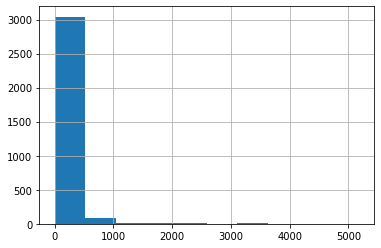

In [10]:
nan_df = df_merged[df_merged.num_nans != 0]
print(nan_df.shape)
display(nan_df.head())
#fig, ax = plt.plot()
nan_df.num_nans.hist()

processing hires gmndwi // elapsed time 0.406 sec
processing hires mndvi // elapsed time 0.555 sec


/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


processing hires mndwi // elapsed time 0.704 sec
processing hires seasonality // elapsed time 0.851 sec
processing hires srtm // elapsed time 0.995 sec
processing hires transition // elapsed time 1.14 sec
processing lores gmndwi // elapsed time 1.303 sec
processing lores mndvi // elapsed time 1.446 sec
processing lores mndwi // elapsed time 1.59 sec
processing lores srtm // elapsed time 1.733 sec


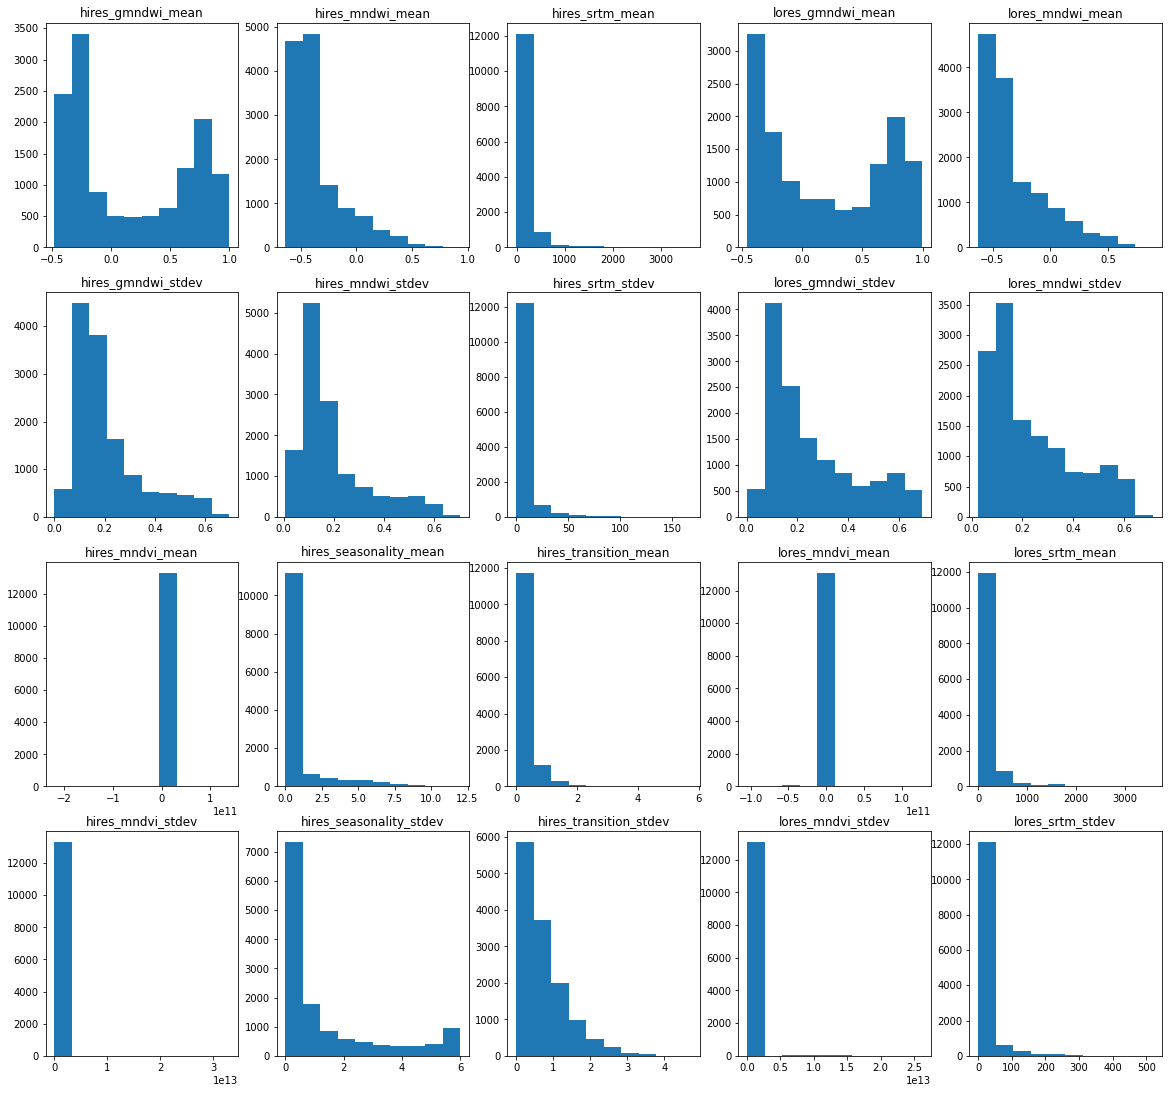

In [11]:
t0 = time.time()
fig, ax = plt.subplots(4,5, figsize = (20,19))
i = 0 
axes = [(x,y) for y in range(5) for x in range(4)]
for res, resdf in df_merged.groupby('img_res'):
    for it, itdf in resdf.groupby('img_type'):
        print('processing', res, it, r'// elapsed time', round(time.time()-t0,3), 'sec')
        ax[axes[i]].hist(list(itdf['mean']))
        ax[axes[i]].set_title(res + '_' + it + '_mean')
        i += 1
        ax[axes[i]].hist(list(itdf['stdev']))
        ax[axes[i]].set_title(res + '_' + it + '_stdev')
        i += 1

In [12]:
ten_layer_setup = [['hires', 'gmndwi'], ['hires', 'mndvi'], ['hires', 'srtm'], # branch 1 hires
               ['hires', 'mndwi'], ['hires', 'seasonality'], ['hires', 'transition'], # branch 2 hires
               ['lores', 'gmndwi'], ['lores', 'mndvi'], ['lores', 'srtm'], ['lores', 'mndwi']] #, branch 3 lores

10 images found.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in log
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in log
  from ipykernel import kernelapp as app


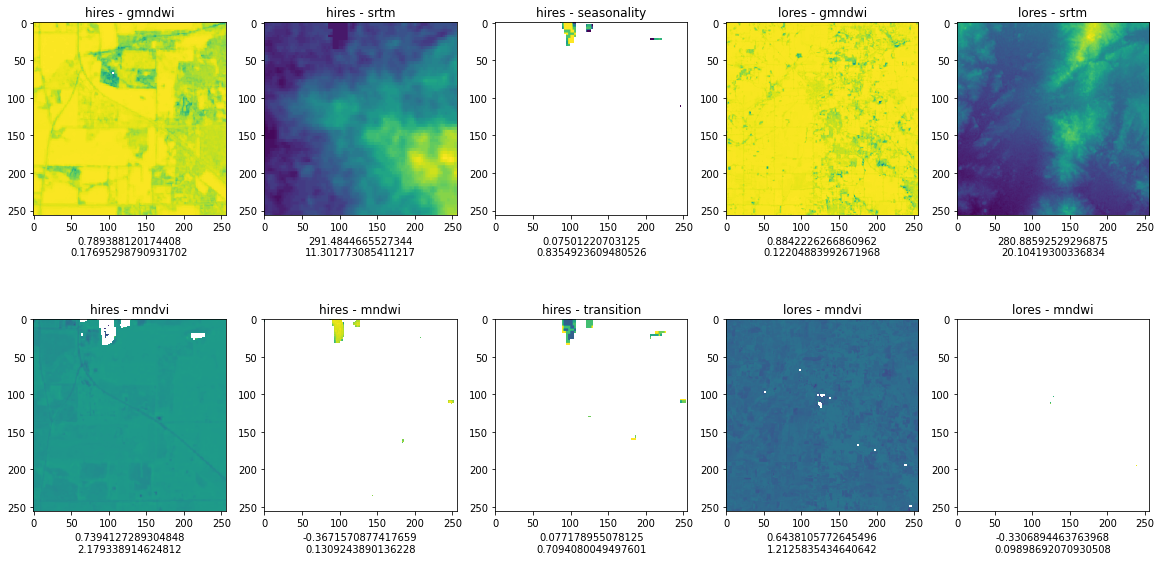

In [13]:
# This function will show images given a lookup table and da_num
def showdaimages(da_num, il_df, layer_setup = ten_layer_setup, image_order = None):
    t0 = time.time()
    df = il_df[il_df['da_num'] == da_num]
    print(df.shape[0], 'images found.')
    fig, ax = plt.subplots(2,5, figsize = (20,10))
    i = 0 
    axes = [(x,y) for y in range(5) for x in range(2)]
    #for idx, row in df.iterrows():
    for ir, it in layer_setup:
        #print(ir,it)
        row = df[(df.img_type == it)&(df.img_res == ir)].iloc[0]
        i_arr = create_array(row['img_path'])
        i_arr = i_arr.reshape(256,256)
        i_arr = np.log(i_arr)
        ax[axes[i]].imshow(i_arr)
        ax[axes[i]].set_title(row['img_res'] + ' - ' + row['img_type'])
        ax[axes[i]].set_xlabel(str(row['mean']) + '\n' + str(row['stdev']))
       # print(row['img_type'])
        i += 1
        #print('_*_*_*_*_*_*_*_*_*_*_*')
        
showdaimages('LRC-2003-22227', df_merged)

<AxesSubplot:>

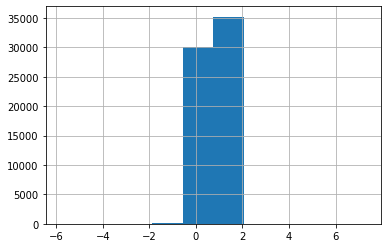

In [32]:
img_p = df_merged[(df_merged.da_num == 'LRC-2003-22227')&(df_merged.img_type == 'mndvi')].img_path.iloc[0]
d = create_array(img_p).flatten()
d = d.clip(np.mean(d)-3*np.std(d),np.mean(d)+3*np.std(d))

pd.Series(d).hist()

In [13]:
layer_setup = [['hires', 'gmndwi'], ['hires', 'mndvi'], ['hires', 'srtm'], # branch 1 hires
               ['hires', 'mndwi'], ['hires', 'seasonality'], ['hires', 'transition'], # branch 2 hires
               ['lores', 'gmndwi'], ['lores', 'mndvi'], ['lores', 'srtm'], ['lores', 'mndwi']] #, branch 3 lores
               #['lores', 'mndwi'], ['lores', 'mndvi'], ['lores', 'srtm']] # branch 4 lores
mean_inception = []
max_values = []
for ir, it in layer_setup:
    #print(ir,it)
    sdf = df_merged[(df_merged.img_type == it)&(df_merged.img_res == ir)]
    print(sdf.shape)
    mean_of_means = np.mean(sdf['mean'])
    mean_inception.append(mean_of_means)
    #
mean_inception        

(12518, 14)
(12577, 14)
(12575, 14)
(12527, 14)
(12562, 14)
(12551, 14)
(12452, 14)
(12485, 14)
(12483, 14)
(12470, 14)


[0.15707907949278074,
 2824699.0901218033,
 167.16802180384119,
 -0.34395557055261655,
 0.7865322572525761,
 0.21961407953596201,
 0.19163081262277507,
 -83517890.07903384,
 172.861189592898,
 -0.3021347216811677]

SAM-2016-01348-APW
10 images found.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in log
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in log
  from ipykernel import kernelapp as app


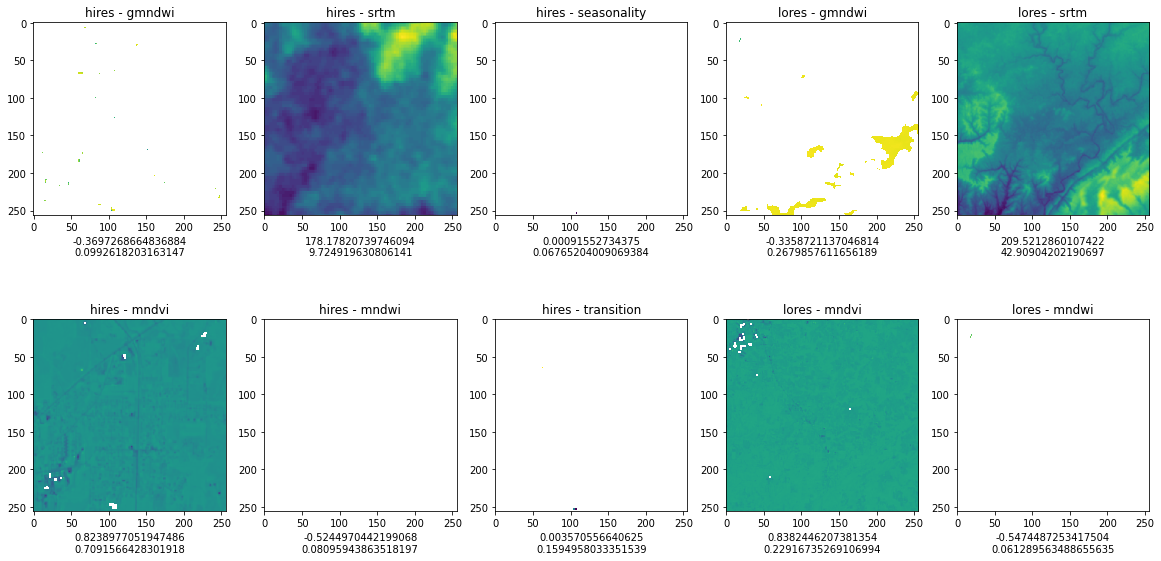

In [16]:
random_da = df_merged.sample()['da_num'].iloc[0]
print(random_da)
showdaimages(random_da, df_merged)

In [10]:
!sync && echo 3 | tee /proc/sys/vm/drop_caches***

tee: /proc/sys/vm/drop_caches: Read-only file system
3


In [30]:
l = np.array([[1,2], [3,4], [7,8000], [2,-4000]])
print(np.mean(l)-3*np.std(l))
l.clip(np.mean(l)-3*np.std(l),7)
l
#d = pd.DataFrame(l, columns = ['t1', 't2'])
#d

-8863.983289611551


array([[    1,     2],
       [    3,     4],
       [    7,  8000],
       [    2, -4000]])

In [34]:
layer_setup3 = [['hires', 'gmndwi'], ['hires', 'mndvi'], ['hires', 'srtm']]

def save_arrays_layer_setup3(df_lookup, location_save, transform_func = None):
    t0 = time.time()
    array_count = 0
    layer_setup3 = [['hires', 'gmndwi'], ['hires', 'mndwi'], ['hires', 'srtm']]
    list_of_problem_da_nums = []
    
    # create transform parameters
    layer_transforms = []
    for layer in layer_setup3:
        layer_subset = df_lookup[(df_lookup['img_res'] == layer[0])&(df_lookup['img_type'] == layer[1])]
        min_min = np.nanmin(layer_subset['min'])
        max_max = np.nanmax(layer_subset['max'])
        mean_mean = np.nanmean(layer_subset['mean'])
        layer_transforms.append([min_min, max_max, mean_mean])
    print('layer_transforms:', layer_transforms)

    
    for da_num, ddf in df_lookup.groupby('da_num'):
        # verify the images are available before exporting
        skip = False
        for layer in layer_setup3:
            image_row = ddf[(ddf['img_res'] == layer[0])&(ddf['img_type'] == layer[1])]
            if image_row.shape[0] < 1:
                skip = True
                break
            elif image_row.shape[0] > 1:
                skip = True
                break
        if skip: 
            print('skipping', da_num, 'not all images or too many images available.')
            list_of_problem_da_nums.append([da_num, 'not all images or too many images available.'])
            continue
        
        # Now create array, transform, and save to .npy file
        try:
            stacked_images = []
            for layer, trans_params in zip(layer_setup3, layer_transforms):
                # create numpy array and save 
                image_row = ddf[(ddf['img_res'] == layer[0])&(ddf['img_type'] == layer[1])]
                i_arr = create_array(image_row.img_path.iloc[0])
                i_arr = np.nan_to_num(i_arr, nan = np.nanmean(i_arr)) # fill nans with mean of array
                if layer[1] == 'mndvi':
                    trans_i_arr = np.clip(np.mean(i_arr)-3*np.std(i_arr),np.mean(i_arr)-3*np.std(i_arr))
                else:
                    min_min = trans_params[0]
                    max_max = trans_params[1]
                    trans_i_arr = (i_arr - min_min) * 1/(max_max - min_min)  # sets min at 0, and scales so max is 1
                stacked_images.append(trans_i_arr)
            print(da_num, end = '\r')
            if skip:
                continue
            np.save(location_save + str(da_num) + '.npy', np.concatenate(stacked_images))

        except Exception as e:
            print('error in', da_num, e)
            list_of_problem_da_nums.append([da_num, 'error in creating array.'])
        array_count += 1

            #break
    print(array_count, 'training examples prepared in', round(time.time()-t0), 'sec')
    df_errors = pd.DataFrame(list_of_problem_da_nums, columns = ['da_num', 'error'])
    return df_errors

# sac_saw (wilmington and richmond) only in '/data/training_datax2/'
#df_sac_saw = df_merged[df_merged.district_code.isin(['SAC', 'SAW'])]

error_dfs = save_arrays_layer_setup3(df_merged, '/data/train_data_hi_3x/')


layer_transforms: [[-0.9956896305084229, 0.9998145699501038, 0.15660452931617638], [-0.9982190560997328, 0.9927272727272728, -0.34741422396072286], [-93.0, 4105.0, 172.97737144272952]]
skipping MVK-2017-00535-TB not all images or too many images available.
skipping MVK-2017-00836-TB not all images or too many images available.
skipping MVK-2017-00838-JLD not all images or too many images available.
skipping MVK-2017-00849-CR not all images or too many images available.
skipping MVK-2017-00855-TB not all images or too many images available.
skipping MVK-2017-00856-TB not all images or too many images available.
skipping MVK-2017-00861-TB not all images or too many images available.
skipping MVK-2017-00909 not all images or too many images available.
skipping MVK-2017-00911-TB not all images or too many images available.
skipping MVK-2017-00915-JLD not all images or too many images available.
skipping MVK-2017-00923-JLD not all images or too many images available.
skipping MVK-2017-00931

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:43: RuntimeWarning: Mean of empty slice


skipping SAW-2015-02549 not all images or too many images available.
skipping SAW-2018-00319 not all images or too many images available.
skipping SWG-2016-00776 not all images or too many images available.
13209 training examples prepared in 1303 sec


In [35]:
error_dfs

,da_num,error
0,MVK-2017-00535-TB,not all images or too many images available.
1,MVK-2017-00836-TB,not all images or too many images available.
2,MVK-2017-00838-JLD,not all images or too many images available.
3,MVK-2017-00849-CR,not all images or too many images available.
4,MVK-2017-00855-TB,not all images or too many images available.
...,...,...
115,POA-2019-00125,not all images or too many images available.
116,POA-2019-00608,error in creating array.
117,SAW-2015-02549,not all images or too many images available.
118,SAW-2018-00319,not all images or too many images available.


In [27]:
layer_setup = [['hires', 'gmndwi'], ['hires', 'mndvi'], ['hires', 'srtm'], # branch 1 hires
               ['hires', 'mndwi'], ['hires', 'seasonality'], ['hires', 'transition'], # branch 2 hires
               ['lores', 'gmndwi'], ['lores', 'mndvi'], ['lores', 'srtm']] #, branch 3 lores
def save_arrays(df_lookup, layer_setup, location_save):
    t0 = time.time()
    array_count = 0
    for da_num, ddf in df_lookup.groupby('da_num'):
        if ddf.shape[0] != 10:
            print(da_num, "error, not 10 images. ", end = " - ")
            continue
            
        else:
            try:
                stacked_images = []
                for channel in layer_setup:
                    image_row = ddf[(ddf['img_res'] == channel[0])&(ddf['img_type'] == channel[1])]
                    #print(image_row, type(image_row))
                    if image_row.shape[0] != 1: 
                        print('Duplicates?', image_row)
                    stacked_images.append(create_array(image_row.img_path.iloc[0]))
                print(da_num, end = '\r')
                np.save(location_save + str(da_num) + '.npy', np.concatenate(stacked_images))

            except:
                print('error in', da_num)
            array_count += 1

            #break
    print(array_count, 'training examples prepared in', round(time.time()-t0), 'sec')
    return 1
    
    
save_arrays(df_merged, layer_setup, '/data/training_data1/')


Error with image: /data/image_final2/GEE_images_final2_lores_srtm_3995_MVN-2019-00361-ST_srtm_lores.tif error, not 10 images.  - MVN-2018-00129-SK error, not 10 images.  - MVN-2018-00132-SG error, not 10 images.  - MVN-2018-00134-SG error, not 10 images.  - MVN-2018-00136-SR error, not 10 images.  - MVN-2018-00142-SKor, not 10 images.  - LRL-2018-01094-LCL error, not 10 images.  - LRL-2018-01105-htm error, not 10 images.  - LRN-2020-00219 error, not 10 images.  - LRN-2020-00307 error, not 10 images.  - LRN-2020-00310 error, not 10 images.  - LRN-2020-00315 error, not 10 images.  - LRN-2020-00351 error, not 10 images.  - LRP-1997-00197 error, not 10 images.  - LRP-2009-00477 error, not 10 images.  - LRP-2013-01406 error, not 10 images.  - LRP-2014-01127 error, not 10 images.  - LRP-2015-01538 error, not 10 images.  - LRP-2016-00100MVN-2016-00528-ST
error in MVN-2019-00361-ST
Error with image: /data/image_final2/GEE_images_final2_lores_srtm_5857_NAN-2016-01232-USH_srtm_lores.tifMG error,

1

In [28]:
layer_setup2 = [['hires', 'gmndwi'], ['hires', 'transition'], ['hires', 'srtm'], # branch 1 hires
               ['hires', 'mndwi'], ['hires', 'seasonality'], ['hires', 'transition'], # branch 2 hires
               ['lores', 'gmndwi'], ['lores', 'mndwi'], ['lores', 'srtm']] #, branch 3 lores
def save_arrays(df_lookup, layer_setup, location_save):
    t0 = time.time()
    array_count = 0
    for da_num, ddf in df_lookup.groupby('da_num'):
        if ddf.shape[0] != 10:
            print(da_num, "error, not 10 images. ", end = " - ")
            continue
            
        else:
            try:
                stacked_images = []
                for channel in layer_setup:
                    image_row = ddf[(ddf['img_res'] == channel[0])&(ddf['img_type'] == channel[1])]
                    #print(image_row, type(image_row))
                    if image_row.shape[0] != 1: 
                        print('Duplicates?', image_row)
                    i_arr = create_array(image_row.img_path.iloc[0])
                    if channel[1] == 'srtm': i_arr / 200. # scale the srtm
                    stacked_images.append(i_arr)
                print(da_num, end = '\r')
                np.save(location_save + str(da_num) + '.npy', np.concatenate(stacked_images))

            except:
                print('error in', da_num)
            array_count += 1

            #break
    print(array_count, 'training examples prepared in', round(time.time()-t0), 'sec')
    return 1
    
    
save_arrays(df_merged, layer_setup2, '/data/training_data2/')


Error with image: /data/image_final2/GEE_images_final2_lores_srtm_3995_MVN-2019-00361-ST_srtm_lores.tif error, not 10 images.  - MVN-2018-00129-SK error, not 10 images.  - MVN-2018-00132-SG error, not 10 images.  - MVN-2018-00134-SG error, not 10 images.  - MVN-2018-00136-SR error, not 10 images.  - MVN-2018-00142-SKor, not 10 images.  - LRL-2018-01094-LCL error, not 10 images.  - LRL-2018-01105-htm error, not 10 images.  - LRN-2020-00219 error, not 10 images.  - LRN-2020-00307 error, not 10 images.  - LRN-2020-00310 error, not 10 images.  - LRN-2020-00315 error, not 10 images.  - LRN-2020-00351 error, not 10 images.  - LRP-1997-00197 error, not 10 images.  - LRP-2009-00477 error, not 10 images.  - LRP-2013-01406 error, not 10 images.  - LRP-2014-01127 error, not 10 images.  - LRP-2015-01538 error, not 10 images.  - LRP-2016-00100MVK-2017-00862-TBMVK-2017-00903-CRMVN-2016-00528-STMVN-2018-00122-SL
error in MVN-2019-00361-ST
Error with image: /data/image_final2/GEE_images_final2_lores_s

1

In [11]:
img_sum_list = []
for da, dadf in df.groupby('da_num'):
    img_sum_list.append(dadf.shape[0])
    if dadf.shape[0] != 10: print(dadf.shape)
len([x for x in img_sum_list if x != 10])

(9, 5)
(5, 5)
(5, 5)
(5, 5)
(5, 5)
(9, 5)
(9, 5)
(7, 5)
(7, 5)
(7, 5)
(6, 5)
(2, 5)
(2, 5)
(2, 5)
(2, 5)
(2, 5)
(2, 5)
(2, 5)
(2, 5)
(2, 5)
(2, 5)
(2, 5)
(2, 5)
(2, 5)
(2, 5)
(2, 5)
(2, 5)
(2, 5)
(2, 5)
(2, 5)
(2, 5)
(2, 5)
(2, 5)
(2, 5)
(2, 5)
(2, 5)
(2, 5)
(2, 5)
(2, 5)
(2, 5)
(9, 5)
(9, 5)
(7, 5)
(8, 5)
(8, 5)
(7, 5)
(7, 5)
(7, 5)
(8, 5)
(8, 5)
(7, 5)
(8, 5)
(7, 5)
(7, 5)
(7, 5)
(7, 5)
(7, 5)
(7, 5)
(7, 5)
(7, 5)
(7, 5)
(7, 5)
(9, 5)
(1, 5)
(1, 5)
(1, 5)
(1, 5)
(2, 5)
(1, 5)
(2, 5)
(1, 5)
(2, 5)
(1, 5)
(2, 5)
(1, 5)
(2, 5)
(1, 5)
(2, 5)
(1, 5)
(2, 5)
(1, 5)
(2, 5)
(1, 5)
(2, 5)
(1, 5)
(2, 5)
(2, 5)
(2, 5)
(2, 5)
(2, 5)
(2, 5)
(2, 5)
(2, 5)
(2, 5)
(2, 5)
(2, 5)
(2, 5)
(2, 5)
(2, 5)
(2, 5)
(2, 5)
(2, 5)
(2, 5)
(2, 5)
(2, 5)
(2, 5)
(2, 5)
(2, 5)
(2, 5)
(2, 5)
(2, 5)
(2, 5)
(2, 5)
(2, 5)
(2, 5)
(2, 5)
(2, 5)
(2, 5)
(2, 5)
(2, 5)
(2, 5)
(2, 5)
(2, 5)
(2, 5)
(2, 5)
(2, 5)
(2, 5)
(2, 5)
(2, 5)
(2, 5)
(2, 5)
(2, 5)
(2, 5)
(2, 5)
(2, 5)
(2, 5)
(2, 5)
(2, 5)
(2, 5)
(2, 5)
(2, 5)
(2, 5)
(2, 5)

248

In [13]:
#fig, ax = plt.subplots(4,5, figsize = (20,19))
#axes = [(x,y) for x in range(4) for y in range(5)]
#print(axes)

In [127]:
tif_image = '/data/image_final2/GEE_images_final2_hires_srtm_8029_POA-2019-00608_srtm_hires.tif'

p = gdal.Open(str(tif_image))
print(p, type(p))
channels = p.RasterCount

# iterate through rasters and add each to the list of layer_list
layer_list = [np.array(p.GetRasterBand(i).ReadAsArray()) for i in range(1,channels+1)] 

None <class 'NoneType'>


AttributeError: 'NoneType' object has no attribute 'RasterCount'

In [147]:
print(df_merged.shape)
df_merged = df_merged[~(df_merged['da_num'] == 'POA-2019-00608')]
print(df_merged.shape)

(20090, 7)
(20080, 7)


In [148]:
def packager1(df_lookup, layer_setup):
    t0 = time.time()
    X = []
    y = []
    for da_num, ddf in df_lookup.groupby('da_num'):
        if ddf.shape[0] != 10:
            print(da_num, "error, not 10 images. ", end = " - ")
            continue
            
        else:
            stacked_images = []
            for channel in layer_setup:
                image_row = ddf[(ddf['img_res'] == channel[0])&(ddf['img_type'] == channel[1])]
                #print(image_row, type(image_row))
                if image_row.shape[0] != 1: 
                    print('Duplicates?', image_row)
                stacked_images.append(create_array(image_row.img_path.iloc[0]))
            X.append(np.array(stacked_images).reshape(1,256,256,len(layer_setup)))
            
            y.append(ddf.cwa_determination.iloc[0])
            # break
    print(len(y), 'training examples prepared in', round(time.time()-t0), 'sec')
    return np.concatenate(X), np.array(y)
    
    
X, y = packager1(df_merged, layer_setup)
print(X.shape, y.shape)

LRB-2004-00299 error, not 10 images.
LRC-2012-00698 error, not 10 images.
LRH-2015-00966-BCR error, not 10 images.
LRH-2018-00971-GUY error, not 10 images.
LRH-2020-00057-SCR error, not 10 images.
MVN-2015-00044-SR error, not 10 images.
MVN-2015-00919-SQ error, not 10 images.
MVN-2019-00883-SL error, not 10 images.
MVP-2008-04451-WAB error, not 10 images.
MVP-2016-02261-RJH error, not 10 images.
NAO-2016-00437-tca error, not 10 images.
NAO-2020-00781-bcd error, not 10 images.
NAP-2010-00830-67 error, not 10 images.
NWO-2016-01637-BIS error, not 10 images.
NWO-2016-02128-BIS error, not 10 images.
NWO-2017-00021-BIS error, not 10 images.
NWO-2019-00281-DEN error, not 10 images.
NWS-2016-00994 error, not 10 images.
POH-2011-00296-RD9 error, not 10 images.
SAW-2019-00663 error, not 10 images.
1995 training examples prepared in 81 sec
(1995, 256, 256, 6) (1995,)


In [166]:
## develop input splitter
from keras.applications.vgg16 import VGG16
vgg16_model1 = VGG16(include_top=False, weights='imagenet', input_shape=(256,256, 3))
vgg16_model2 = VGG16(include_top=False, weights='imagenet', input_shape=(256,256, 3))
vgg16_model1.trainable = False
vgg16_model2.trainable = False

print(type(vgg16_model1))
vgg16_model1.summary()

<class 'tensorflow.python.keras.engine.functional.Functional'>
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
________________________________________________________________

In [186]:
s = np.random.rand(256,256,6)
print(s[2,2])
t0 = time.time()
np.save('/data/test.npy', s)
t = np.load('/data/test.npy')
print(t[2,2])
print(time.time()-t0)

[0.22833636 0.45173023 0.3793516  0.65842719 0.77616611 0.01508382]
[0.22833636 0.45173023 0.3793516  0.65842719 0.77616611 0.01508382]
0.13897180557250977


In [171]:
import pickle
def pickle_write(loc, s_in):
    with open("/data/test.pkl", "wb") as f:
        pickle.dump(s_in, f)
def pickle_load(s_arra):
    with open(s_arra, 'rb') as f:
        return pickle.load(f)

In [179]:
s = np.random.rand(256,256,6)
print(s[2,2])
t0 = time.time()
pickle_write('/data/test.pkl', s)
t = pickle_load('/data/test.pkl')
print(t[2,2])
print(time.time()-t0)

[0.04989276 0.16162271 0.6235208  0.21704524 0.15056739 0.48738028]
[0.04989276 0.16162271 0.6235208  0.21704524 0.15056739 0.48738028]
0.13547706604003906


In [158]:
test_input = np.random.rand(256,256,3)
test_input = test_input.reshape(1, 256,256, 3)
print(test_input.shape)
vgg16_model1.predict(test_input)

(1, 256, 256, 3)


NameError: name 'vgg16_model1' is not defined

In [149]:
for i in range(2):
    s = np.random.rand(256,256,6)[:,:, i*3:3*(i+1)].shape
    print(s[:3,:1])

TypeError: tuple indices must be integers or slices, not tuple

In [179]:
from keras.layers import Dense, Concatenate, Input, Lambda, Flatten, Softmax
from keras.models import Model, Sequential

num_channels = 6
input = Input(shape=(256,256, num_channels))

branch_outputs = []

# loop for however many branches you want to use.  (each branch needs 3 channel depth)
for i in [0,3]:
    # create looping so that vgg16 model input is created ie 256,256,3
    print(input.shape)
    out = Lambda(lambda x: x[:,:,:,i:i+3])(input)
    print(out.shape)
    
    # Setting up your layers in each branch: (currently each branch is identical architecture.)
    if i == 0: out = Sequential(vgg16_model1)(out)   # use pretrained and loaded vgg16
    else: out = Sequential(vgg16_model1)(out)   # use pretrained and loaded vgg16
    print(out.shape)
    out = Dense(10)(out)
    print(out.shape)
    out = Flatten()(out)
    print(out.shape)
    branch_outputs.append(out)

# Concatenating the branches outputs:
out = Concatenate()(branch_outputs)
print(out.shape)

# Add final dense layers and softmax
out = Dense(10)(out)
print(out.shape)
out = Dense(6)(out)
out = Dense(2)(out)
print(out.shape)
out = Softmax()(out)
print(out.shape)

(None, 256, 256, 6)
(None, 256, 256, 3)
(None, 8, 8, 512)
(None, 8, 8, 10)
(None, 640)
(None, 256, 256, 6)
(None, 256, 256, 3)
(None, 8, 8, 512)
(None, 8, 8, 10)
(None, 640)
(None, 1280)
(None, 10)
(None, 2)
(None, 2)


In [175]:
!nvidia-smi

Mon Mar  1 00:06:58 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.80.02    Driver Version: 450.80.02    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           On   | 00000000:00:1E.0 Off |                    0 |
| N/A   48C    P0    59W / 149W |  10868MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [180]:
model = Model(inputs=input, outputs=out)   
model.summary()
#plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

Model: "functional_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_15 (InputLayer)           [(None, 256, 256, 6) 0                                            
__________________________________________________________________________________________________
lambda_12 (Lambda)              (None, 256, 256, 3)  0           input_15[0][0]                   
__________________________________________________________________________________________________
lambda_13 (Lambda)              (None, 256, 256, 3)  0           input_15[0][0]                   
__________________________________________________________________________________________________
sequential_9 (Sequential)       (None, 8, 8, 512)    14714688    lambda_12[0][0]                  
_______________________________________________________________________________________

In [181]:
predicts = model.predict(X)

In [18]:
predicts

array([[0.52614987, 0.47385013],
       [0.50729644, 0.49270362],
       [0.4020764 , 0.59792364],
       [0.5092877 , 0.49071234],
       [0.558615  , 0.44138497],
       [0.5424467 , 0.4575533 ],
       [0.6158485 , 0.38415152],
       [0.9279001 , 0.07209992],
       [0.91072845, 0.08927153],
       [0.7216913 , 0.27830866],
       [0.69085824, 0.30914176],
       [0.6877592 , 0.31224078],
       [0.49993137, 0.50006866],
       [0.6228172 , 0.37718278],
       [0.79717696, 0.20282304],
       [0.57873434, 0.4212657 ],
       [0.6701145 , 0.32988548],
       [0.4465543 , 0.5534457 ],
       [0.47780797, 0.522192  ],
       [0.6321457 , 0.3678543 ],
       [0.4218403 , 0.5781597 ],
       [0.7781874 , 0.22181265],
       [0.50960356, 0.49039644],
       [0.51452   , 0.48548   ],
       [0.47596624, 0.5240337 ],
       [0.60892016, 0.39107987],
       [0.6190333 , 0.38096675],
       [0.76610214, 0.23389782],
       [0.64370394, 0.35629612],
       [0.46383935, 0.5361606 ],
       [0.

In [177]:
model.compile(optimizer='sgd',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [182]:
from sklearn.model_selection import train_test_split

ModuleNotFoundError: No module named 'sklearn'

In [178]:
t0 = time.time()
model.fit(X, y, epochs=60, batch_size=64, validation_split = 0.2, workers=4, use_multiprocessing=True)
print("Train time:", time.time()-t0)

Epoch 1/2
25/25 [==============================] - 33s 1s/step - loss: 4.8270 - accuracy: 0.3503 - val_loss: 6.2763 - val_accuracy: 0.3885
Epoch 2/2
25/25 [==============================] - 33s 1s/step - loss: 4.6937 - accuracy: 0.3346 - val_loss: 6.2206 - val_accuracy: 0.3985
Train time: 73.5788266658783


In [39]:
import time
test_input = np.random.rand(256,256,6)
test_input = test_input.reshape(1, 256,256, 6)
print(test_input.shape)
t0 = time.time()
print(model.predict(test_input))
print(f"time taken: {time.time()-t0} seconds")

(1, 256, 256, 6)
[[0.4622121 0.537788 ]]
time taken: 0.9495842456817627 seconds


In [13]:
test_input.flatten().min()

9.019184943337422e-08

In [11]:
from keras_visualizer import visualizer 
visualizer(model, format='png', view=True)


ValueError: Keras Visualizer: Layer not supported for visualizing

In [7]:
import IPython
print(IPython.sys_info())

{'commit_hash': '2486838d9',
 'commit_source': 'installation',
 'default_encoding': 'ANSI_X3.4-1968',
 'ipython_path': '/usr/local/lib/python3.6/dist-packages/IPython',
 'ipython_version': '7.16.1',
 'os_name': 'posix',
 'platform': 'Linux-4.9.140-tegra-aarch64-with-Ubuntu-18.04-bionic',
 'sys_executable': '/usr/bin/python3',
 'sys_platform': 'linux',
 'sys_version': '3.6.9 (default, Oct  8 2020, 12:12:24) \n[GCC 8.4.0]'}


In [38]:
import IPython
print(IPython.sys_info())

{'commit_hash': '2486838d9',
 'commit_source': 'installation',
 'default_encoding': 'UTF-8',
 'ipython_path': '/usr/local/lib/python3.6/dist-packages/IPython',
 'ipython_version': '7.16.1',
 'os_name': 'posix',
 'platform': 'Linux-5.4.0-1037-aws-x86_64-with-Ubuntu-18.04-bionic',
 'sys_executable': '/usr/bin/python3',
 'sys_platform': 'linux',
 'sys_version': '3.6.9 (default, Jan 26 2021, 15:33:00) \n[GCC 8.4.0]'}
